In [2]:
# -*- coding: utf8 -*-

import argparse
import math
import os.path
import time

import numpy as np

from pydrake.all import (VectorSystem)

ground_angle = 0.0

class BipedalSpringMass2dController(VectorSystem):
    def __init__(self, model, 
        desired_lateral_velocity = 0.0,
        print_period = 0.0,
        print_step = True):
        '''
        Controls a planar model described
        in bipedal_spring_mass.sdf.

        :param model: A pydrake RigidBodyTree() loaded
            from bipedal_spring_mass.sdf.
        :param desired_lateral_velocity: How fast should the controller
            aim to run sideways?
        :param print_period: If nonzero, this controller will print to
            the python console every print_period (simulated) seconds
            to indicate simulation progress.
        '''
        VectorSystem.__init__(self,
            14, # 10 inputs: x, z, theta, alpha, l, and their derivatives
            4) # 2 outputs: Torque on thigh, and force on the leg extension
               #  link. (The passive spring for on the leg is calculated as
               #  part of this output.)
        self.model = model
        self.desired_lateral_velocity = desired_lateral_velocity
        self.print_period = print_period
        self.last_print_time = -print_period
        # Remember what the index of the foot is
        self.foot_body_indices = [model.FindBody("foot{}".format(n)).get_body_index() for n in (1,2)]

        self.model_leg_length = 1.

        self.order = 1    
        
        # This is an arbitrary choice of spring constant for the leg.
        self.K_l = 5.
        self.steps = 0
        
    def foot_locs(self,X):    
        kinsol = self.model.doKinematics(X)
        foot_point = np.array([0.0, 0.0, -self.model_leg_length])
        
        return np.array([self.model.transformPoints(kinsol, 
                        foot_point, i, 0) for i in self.foot_body_indices])
        
    def foot_heights(self,X):    
        # Run out the forward kinematics of the robot
        # to figure out where the foot is in world frame.
        return self.foot_locs(X)[:,2].flatten()
        
    def on_ground( self,X):
        feet = self.foot_locs(X)
        return  (feet[:,2] <= -feet[:,0]*np.sin(ground_angle) + .025).flatten()
           
    def ChooseSpringRestLengths(self, X):
        '''
        Given the system state X,
            returns a (scalar) rest length of the leg spring.
            We can command this instantaneously, as
            the actual system being simulated has perfect
            force control of its leg extension.
        
        :param X: numpy array, length 10, full state of the model.

        :return: 2 float, the desired rest lengths of the model leg spring
                    to enforce.
        '''
        # Unpack states
        x, z, theta, alpha1, l1, alpha2, l2 = X[0:7]
        zd = X[8]
        
        on_ground = self.on_ground(X)
        in_air = np.logical_not(on_ground)
        
        back, front = [0,1][::self.order]
        angles = np.array([alpha1, alpha2]) + theta
        backl, frontl = [l1, l2][::self.order]
        f_back , f_front = self.foot_locs(X)[::self.order]
        backh = backl*np.cos(angles[back])
        
        #short = in_air  #only shorten leg if in air
        #short[back] = 0 #only shorten led front leg
        
        K = 0.7
        
        short = np.array([0,0])
        short[front] = (f_front[0] < f_back[0] + 0.1) #only shorten if front leg is behind
        #print(short)
        l_long = self.model_leg_length*np.logical_not(short)
        l_short = K*backl*short
        
        return l_long+l_short
        
        #lengths = np.array([0,0])
        #lengths[back] = self.model_leg_length
        
        #lengths[front] = 0.7 if f_front[0] < f_back[0] + 0.1 else 1 #only shorten if front leg is behind
        #lengths[front] = lengths[front] * backl * np.cos(angles[back])/np.cos(angles[front])
        #lengths[front] = lengths[front] if abs(angles[front] - self.angle_air) > .1 else self.model_leg_length

        #return lengths

    def ChooseThighTorques(self, X, angles_desired = None):
        '''
        Given the system state X,
            returns a tordue for alpha
        
        :param X: numpy array, length 10, full state of the model.

        :return: 2 floats, the torques to exert at the leg angle joint.
        '''
        x, z, theta, alpha1, l1, alpha2, l2 = X[0:7]
        xd, zd, thetad, alpha1d, l1d, alpha2d, l2d = X[7:]
        
        if angles_desired is None:
            angles_desired = np.array([0]*2)
            
        angles_desired = np.array(angles_desired)
        
        angles = np.array([alpha1, alpha2]) + theta
       
        #angles = angles % (2*np.pi)
        #angles += 2*np.pi*(angles<0)
        #angles_desired += 2*np.pi*(angles_desired<0)
        
        angle_vs = np.array(alpha1d, alpha2d)# + thetad
        #print(angles)
        #print(not self.in_contact(X))
        
        K_a =  30.
        B =  0.
        K_g =  7.
        
        on_ground = self.on_ground(X)
        in_air = np.logical_not(on_ground)

        K_a = K_a*in_air
        K_g = K_g*on_ground
        
        return (K_a + K_g) * (angles_desired-angles) -  B*(angle_vs)*in_air
            

    def _DoCalcVectorOutput(self, context, u, x, y):
        '''
        Given the state of the model (as the input to this system,
        u), populates (in-place) the control inputs to the model
        (y). This is given the state of this controller in x, but
        this controller has no state, so x is empty.

        :param u: numpy array, length 14, full state of the model.
        :param x: numpy array, length 0, full state of this controller.
        :output y: numpy array, length 4, control input to pass to the
            model.
        '''

        # The naming if inputs is confusing, as this is a separate
        # system with its own state (x) and input (u), but the input
        # here is the state of the model.
        x, z, theta, alpha1, l1, alpha2, l2 = u[0:7]
        xd, zd, thetad, alpha1d, l1d, alpha2d, l2d = u[7:]
        v = xd
        
        on_ground = self.on_ground(u)
        in_air = np.logical_not(on_ground)
        back,front =  [0,1][::self.order]
        
        # Apply a force on the leg extension prismatic joint
        # that simulates the passive spring force (given the
        # chosen l_rest).
        
        # Print the current time, if requested,
        # as an indicator of how far simulation has
        # progressed.
        if (self.print_period and
            context.get_time() - self.last_print_time >= self.print_period):
            print "t: ", context.get_time()
            self.last_print_time = context.get_time()

        max_dv = 1.5  
        vdes = self.desired_lateral_velocity
        error = (vdes-v)
        
        vdes -= abs(error)//max_dv*np.sign(error)
        error = vdes-v

        self.angle_air = -vdes/10
        self.angle_ground = -self.angle_air*1.0
        
        K = 0.05
        self.angle_ground += K*error
        
        on_ground = self.on_ground(u)
        back,front =  [0,1][::self.order]
        
        feet = self.foot_locs(u)
    
        #print(feet[:,2], -feet[:,0]*np.sin(.05))
        
        if on_ground[front]:
            #print(feet[front][0] - u[0])
            pass
        
        if on_ground[front] and feet[front][0] - u[0] > .01 and feet[back][0] - u[0] < -.01:
            self.order = -self.order
            #pass
            self.steps +=1
            if self.print_period:
                print("step",[alpha1, alpha2][::self.order], vdes,xd)
                                               
        l_rest = self.ChooseSpringRestLengths(X = u)
        #print(l_rest)
        l = np.array([u[4],u[6]])
        l_dot = np.array([u[4+7],u[6+7]])
        leg_compression_amount = -l + l_rest
        #print(leg_compression_amount)
        K_D = 5
        fs = self.K_l * leg_compression_amount - K_D*l_dot*in_air    
        
        angles = [self.angle_ground,self.angle_air][::self.order]
        tmax = 5.
        ts = self.ChooseThighTorques(X = u, angles_desired = angles)
        
        #print(ts)
        ts = [t if abs(t) < tmax else tmax*t/abs(t) for t in ts]

        output = [ts[0], fs[0], ts[1], fs[1]]
        
        #print(angles, 'desired')
        #print(u[3],u[5], 'actual')
        #print(ts, 'torques')
        #print(u[4],u[6], 'disps')
        #print(fs, 'forces')
        
        y[:] =  output
        #print(y)


In [3]:
from pydrake.all import (DirectCollocation, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult)
from underactuated import (PlanarRigidBodyVisualizer)

from pydrake.all import (DiagramBuilder, FloatingBaseType, Simulator, VectorSystem,
                        ConstantVectorSource, SignalLogger, CompliantMaterial,
                         AddModelInstancesFromSdfString)
from IPython.display import HTML
import matplotlib.pyplot as plt

'''
Simulates a 2d model from initial conditions x0 (which
should be a 10x1 np array) for duration seconds,
targeting a specified lateral velocity and printing to the
console every print_period seconds (as an indicator of
progress, only if print_period is nonzero).
'''
def Simulate2dBipedalSpringMass(x0, duration,
        desired_lateral_velocity = 0.0,
        print_period = 0.0):
    builder = DiagramBuilder()

    # Load in the model from a description file.
    # It's spawned with a fixed floating base because
    # the robot description file includes the world as its
    # root link -- it does this so that I can create a robot
    # system with planar dynamics manually. (Drake doesn't have
    # a planar floating base type accessible right now that I
    # know about -- it only has 6DOF floating base types.)
    tree = RigidBodyTree()
    AddModelInstancesFromSdfString(
        open("bipedal_spring_mass.sdf", 'r').read(),
        FloatingBaseType.kFixed,
        None, tree)

    # A RigidBodyPlant wraps a RigidBodyTree to allow
    # forward dynamical simulation. It handles e.g. collision
    # modeling.
    plant = builder.AddSystem(RigidBodyPlant(tree))
    
    noutputs = plant.get_output_size()
    nstates = plant.get_num_states()
    ninputs  = plant.get_input_size()
    #print("outputs: {},states: {}, inputs: {}".format(noutputs,nstates, ninputs))
    #print("x0: {}".format(len(x0)))
    assert(len(x0) == nstates)
    
    # Alter the ground material used in simulation to make
    # it dissipate more energy (to make the hopping more critical)
    # and stickier (to make the model less likely to slip).
    allmaterials = CompliantMaterial()
    allmaterials.set_youngs_modulus(1E8) # default 1E9
    allmaterials.set_dissipation(1.0) # default 0.32
    allmaterials.set_friction(.5) # default 0.9.
    plant.set_default_compliant_material(allmaterials)

    # Spawn a controller and hook it up
    controller = builder.AddSystem(
        BipedalSpringMass2dController(tree,
            desired_lateral_velocity = desired_lateral_velocity,
            print_period = print_period))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))

    # Create a logger to log at 30hz
    state_log = builder.AddSystem(SignalLogger(plant.get_num_states()))
    #state_log._DeclarePeriodicPublish(0.00333, 0.0) # 300hz logging
    builder.Connect(plant.get_output_port(0), state_log.get_input_port(0))

    # Create a simulator
    diagram = builder.Build()
    simulator = Simulator(diagram)
    # Don't limit realtime rate for this sim, since we
    # produce a video to render it after simulating the whole thing.
    #simulator.set_target_realtime_rate(100.0) 
    simulator.set_publish_every_time_step(True)

    # Force the simulator to use a fixed-step integrator,
    # which is much faster for this stiff system. (Due to the
    # spring-model of collision, the default variable-timestep
    # integrator will take very short steps. I've chosen the step
    # size here to be fast while still being stable in most situations.)
    integrator = simulator.get_mutable_integrator()
    integrator.set_fixed_step_mode(True)
    integrator.set_maximum_step_size(0.0005)

    # Set the initial state
    state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
    state.SetFromVector(x0)

    # Simulate!
    simulator.StepTo(duration)

    return tree, controller, state_log

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from underactuated import PlanarRigidBodyVisualizer

x0 = np.array([0.]*14) #x z t a1 l1 a2 l2 xd zd td a1d l1d a2d l2d
x0[0] = -45.
x0[1] = 1.78

x0[3] = 0.05
x0[5] = -0.05

x0[4] = 0.75
x0[6] = 0.75

x0[7] = 1.0

#x0 = np.array([  1,   1.78180727e+00,   1.14310696e+00,
#        -1.11987875e+00,   7.82803176e-01,  -1.15519669e+00,
#         6.15992340e-01,   8.48691624e-01,  -2.34774226e-02,
#         4.11358708e-02,   4.12599015e-01,  -1.53911708e-02,
#        -4.18560853e-01,   3.94141813e+00])
# Run the simulation
duration = 20
try:
    robot, controller, state_log = \
        Simulate2dBipedalSpringMass(x0 = x0,
                                   duration=duration,
                                   desired_lateral_velocity = 2.0,
                                   print_period= 1.)

    print "Done!"

except:
        %tb
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
t:  0.0
('step', [-0.18742098502624832, 0.22801546250523261], 2.0, 1.0295992496796746)
('step', [-0.20085906784556096, 0.050180251457311059], 2.0, 1.9602062193732044)
('step', [-0.1989523207075336, 0.21853914001220084], 2.0, 2.1364361346383403)
('step', [-0.19979860409563122, 0.055715971142050222], 2.0, 2.387272136841347)
t:  1.00025
('step', [-0.19655747653857769, 0.23398053108184635], 2.0, 2.1122425254230457)
('step', [-0.19454877914770558, 0.24755260373031598], 2.0, 1.7095213270632301)
t:  2.0005
('step', [-0.19306573388294557, 0.2309753568830383], 2.0, 1.8281753490774491)
('step', [-0.19191842069387877, 0.23298611426873833], 2.0, 1.8475967824082464)
t:  3.0005
('step', [-0.19094331665749548, 0.23284903023754117], 2.0, 1.8879021503641613)
('step', [-0.1900470935785539, 0.23491672300630884], 2.0, 1.91582362012652)
('step', [-0.18907888770014686, 0.21953362845831853], 2.0, 1.999664913992333)
t:  4.

In [7]:
# Visualize the simulation as a vide
viz = PlanarRigidBodyVisualizer(robot, xlim=[-45, 45], ylim=[-1, 1])
viz.fig.set_size_inches(10, 5)

ani = viz.animate(state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display



Spawning PlanarRigidBodyVisualizer for tree with 4 actuators


/usr/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python2.7/dist-packages/scipy/interpolate/interpolate.py:552: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


steps: 315, sections:120


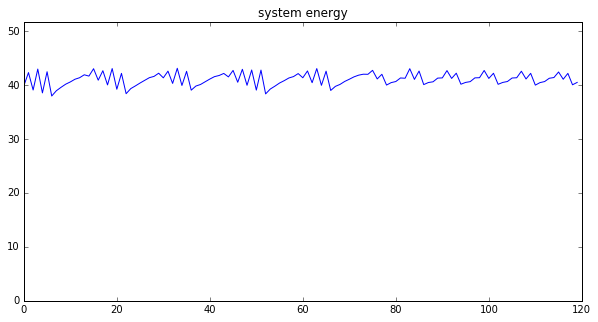

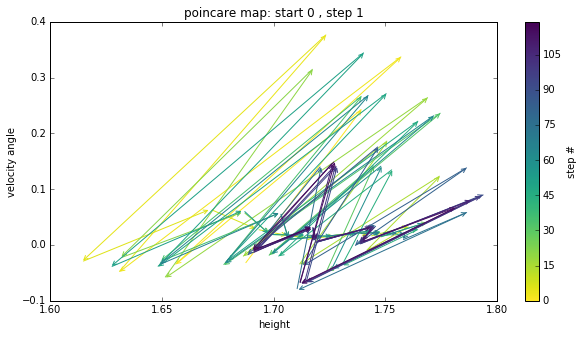

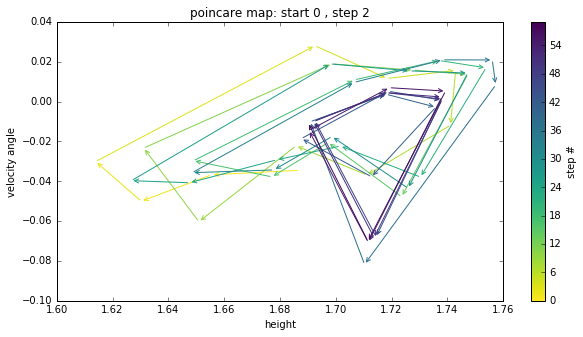

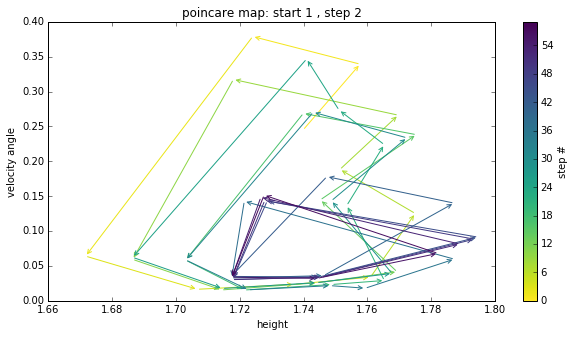

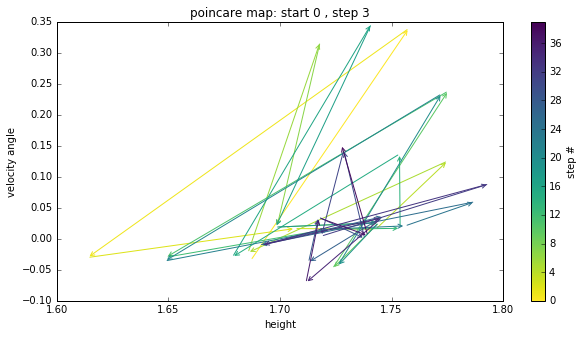

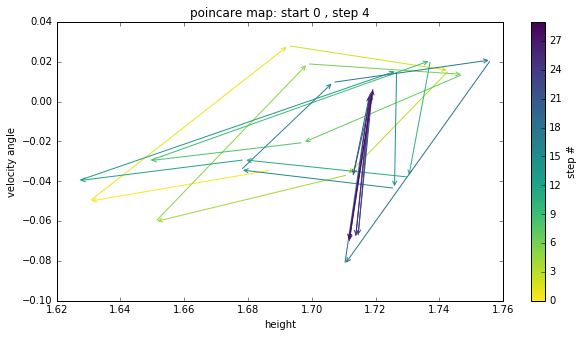

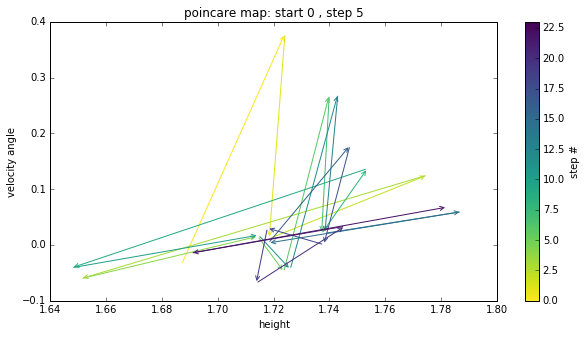

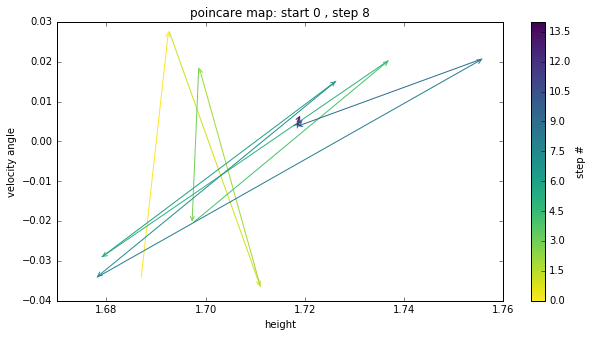

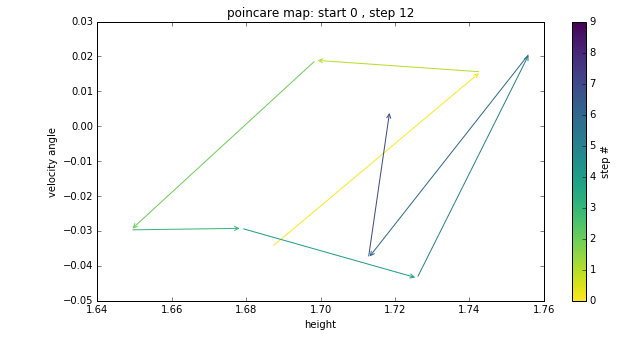

In [250]:
zs = []
os = []
es = []
ts = []
m = 1
k = controller.K_l
tp = 0    
    
for time, state in zip(state_log.sample_times(), np.transpose(state_log.data())):
    if time>43:
        continue
    x, z, t, a1, l1, a2, l2, xd, zd, td, a1d, l1d, a2d, l2d = state
    on_ground = controller.on_ground(state)
    feet = controller.foot_locs(state)
    
    for f,alpha in zip(feet, (a1d, a2d)):
        #print(alpha, f[0])
        if alpha>0 and abs(f[0]-x) < .001:
            if time - tp > .01: #duration/len(state_log.sample_times()):
                zs.append(z)
                os.append(np.arctan(zd/xd))
                es.append(2*m/2*(xd**2 + zd**2) + 2*m*9.8*(z) + k/2*(min(controller.model_leg_length - z, 0))**2)
                #print(time-tp)
                ts.append(time)
            tp = time  
            
plt.figure().set_size_inches(10, 5)
plt.plot(es)
plt.title("system energy")
plt.ylim([0, max(es)*1.2])
#plt.figure().set_size_inches(10, 5)
#plt.plot(zs, os)

x_p = np.array([zs, os])

print("steps: {}, sections:{}".format(controller.steps, len(x_p[0,:])))

def plot_poincare(xps, start=0, step=1):
    
    plt.figure().set_size_inches(10, 5)
    
    plt.title("poincare map: start {} , step {}".format(start, step))
    plt.xlabel('height')
    plt.ylabel('velocity angle')
    
    steps = range(max(len(xp[0,start::step]) for xp in xps))
    
    cmap = plt.cm.ScalarMappable(cmap = 'viridis_r')
    cmap.set_array(steps)
    colors = cmap.to_rgba(steps)
    
    for xp in xps:
        xp = xp[:,start::step]
            
        #plt.plot(xp[0,0],xp[1,0],'bo')
        #plt.plot(xp[0,-1],xp[1,-1],'ro')
        
        #plt.legend(['start','end'])  

        for i in range(len(xp[0,:])-1):
            x,y = xp[:,i]
            #t = ts[i]
            dx, dy = xp[:,i+1]-xp[:,i]

            plt.plot(x,y)
            plt.annotate("", xy=xp[:,i+1], xytext=xp[:,i], arrowprops=dict(arrowstyle="->", color = colors[i]))
            #print(np.linalg.norm(xp[:,i+1]-xp[:,i]))  

    cbar = plt.colorbar(cmap)
    cbar.set_label("step #")

plot_poincare([x_p])
plot_poincare([x_p],step=2)
plot_poincare([x_p],start=1,step=2)
plot_poincare([x_p],start=0,step=3)
plot_poincare([x_p],start=0,step=4)
plot_poincare([x_p],start=0,step=5)
plot_poincare([x_p],start=0,step=8)
plot_poincare([x_p],start=0,step=12)

('step time estimate:', 0.35714285714285715)
('bounce time estimate:', 1.8990312499994759)
('period', 5.3172874999985327)


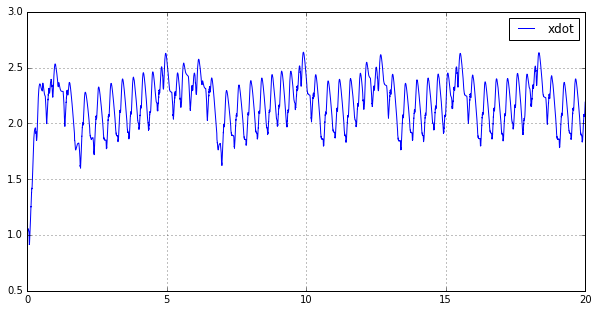

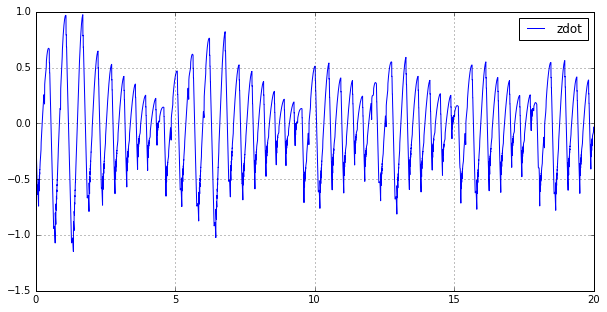

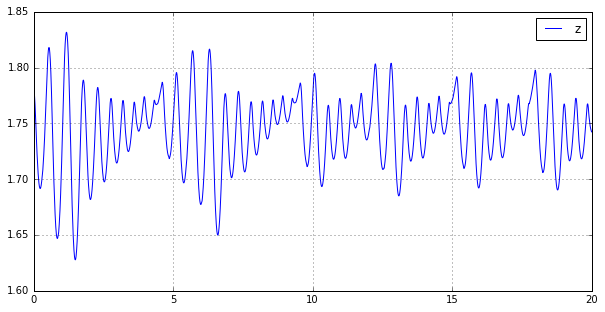

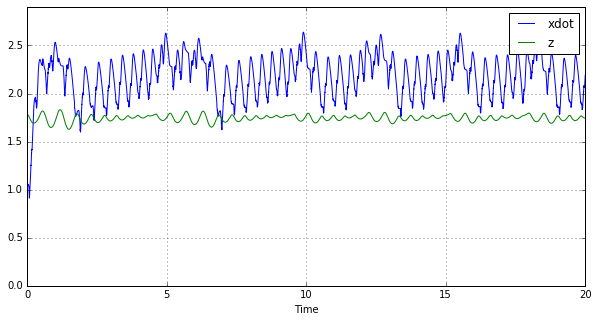

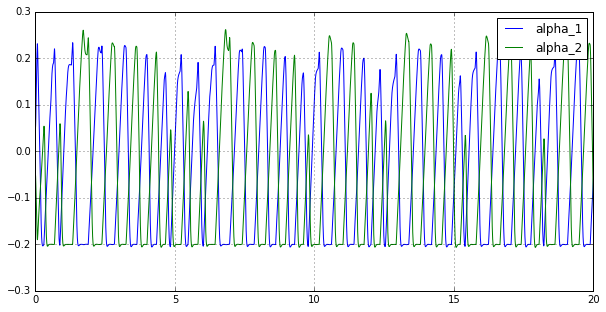

In [17]:
plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[0+7, :])
plt.legend(["xdot"])
plt.grid(True)

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[1+7, :])
plt.legend(["zdot"])
plt.grid(True)

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[1, :])
plt.legend(["z"])
plt.grid(True)

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[0+7, :])
plt.plot(state_log.sample_times(), state_log.data()[1, :])
plt.legend(["xdot","z"])
plt.xlabel('Time')
plt.ylim([0, max(max(state_log.data()[0+7, :]), max(state_log.data()[1, :]))*1.1])
plt.grid(True)


plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[3, :]+state_log.data()[2, :])
plt.plot(state_log.sample_times(), state_log.data()[5, :]+state_log.data()[2, :])
plt.legend(["alpha_1", "alpha_2"])
plt.grid(True)

def find_period(S):
    L = len(S)//2
    
    #print(L)
    S = S[L:]
    #plt.figure().set_size_inches(10, 5)
    #plt.plot(S)
    dpeak = (max(S)-min(S))/50
    #print(dpeak)
    mt1 = 10
    mt2 = 2000
    peaks = range(mt2, L-mt2)
    #print(len(peaks))

    is_peak = lambda m1,m2,d: all(S[p-i]<=S[p]+d and S[p+i]<=S[p]+d for i in range(m1,m2))
    peaks = [p for p in peaks if is_peak(0,mt1,0) and is_peak(mt1,mt2,dpeak)] 

    times = state_log.sample_times()
    peak_ts = np.array([times[p] for p in peaks])
    diffs = peak_ts[1:] - peak_ts[:-1]
    #print(diffs)
    return np.mean(diffs) if any(diffs) else 0
    

def find_bounce(states, indices = (1,7,3,8)):
    return sum(find_period(states[i,:]) for i in indices)/len(indices)

    #print(len(zs))
    
    
t_bounce = find_bounce(state_log.data())
t_step = float(duration)/float(controller.steps)


print("step time estimate:", t_step)
print('bounce time estimate:',t_bounce)
print("period", t_bounce/t_step)




(88, 88)


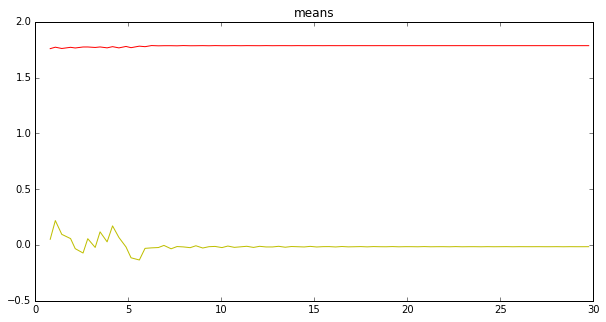

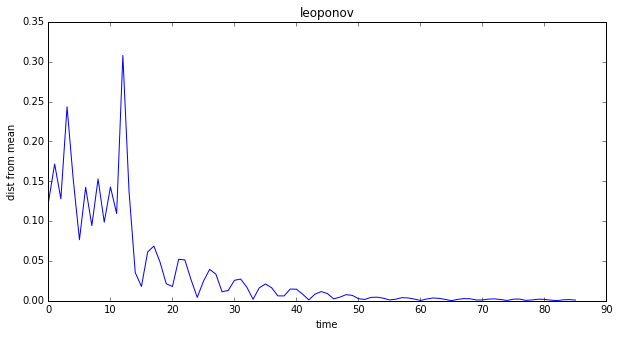

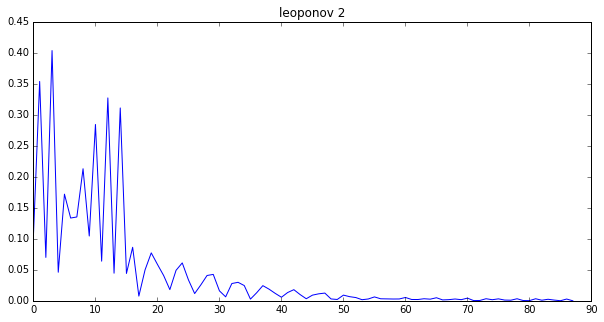

In [7]:
print(len(ts), len(x_p[0,:]))
Ls = []
ms = []
for i in range(2, len(ts)):
    coords = [x_p[:,j] for j in range(i-2, i+1)]
    mean = sum(coords)/3
    #print(coords, mean)
    dist = np.linalg.norm(coords[-1] - mean)
    Ls.append(dist)
    ms.append(mean)

plt.figure().set_size_inches(10, 5)
plt.title("means")
ms = np.array(ms)
plt.plot(ts[2:],ms[:,0],'r')
plt.plot(ts[2:],ms[:,1],'y')

step = 1

plt.figure().set_size_inches(10, 5)
plt.title("leoponov")
plt.xlabel('time')
plt.ylabel('dist from mean')
#plt.plot(Ls)
for i in range(step):
    plt.plot(Ls[i::step])

plt.figure().set_size_inches(10, 5)
plt.title("leoponov 2")
x_pp = x_p[:,::step]
d = np.array([x_pp[:,i] - x_p[:,-1] for i in range(len(x_pp[0,:]))])
#print(d)
n = np.linalg.norm(d, axis = 1)
#print(n)
plt.plot(n)




(0.5, 0.5)
(2.2532747159088218, 0.67261931818173781, 0.29850746268656714)


(0.5, 1.0)
(2.2422164860137923, 0.65947543706288014, 0.29411764705882354)


(0.5, 1.5)
(2.5648247395829653, 0.77721961805544404, 0.30303030303030304)


(0.5, 2.0)
(2.3164275841344377, 0.67142828525635878, 0.2898550724637681)


(0.5, 2.5)
(2.4661076486010569, 0.71481381118871223, 0.2898550724637681)


(0.5, 3.0)
(2.7672013221150857, 0.8020873397435031, 0.2898550724637681)


(1.0, 0.5)
(2.192552307692079, 0.60904230769224421, 0.2777777777777778)


(1.0, 1.0)
(2.2217444711535879, 0.60869711538454463, 0.273972602739726)


(1.0, 1.5)
(2.1868334134612502, 0.59103605769222978, 0.2702702702702703)


(1.0, 2.0)
(2.181490945512587, 0.58959214743583432, 0.2702702702702703)


(1.0, 2.5)
(2.3248137019228348, 0.61995032051275589, 0.26666666666666666)


(1.0, 3.0)
(2.227875437062742, 0.6021284965034438, 0.2702702702702703)


(1.5, 0.5)
(2.028535795454331, 0.62416486013979422, 0.3076923076923077)


(1.5, 1.0)
(2.049083894230

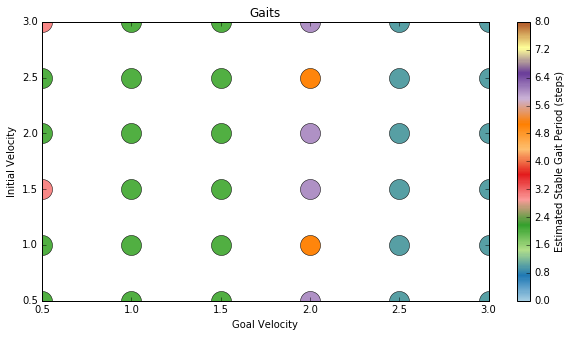

In [209]:
plt.figure().set_size_inches(10, 5)
plt.title("Gaits")
plt.xlabel('Goal Velocity')
plt.ylabel('Initial Velocity')



cmap = plt.cm.ScalarMappable(cmap = 'Paired')
cmap.set_array(np.array(range(9)))

cbar = plt.colorbar(cmap)
cbar.set_label("Estimated Stable Gait Period (steps)")
periods = {}

vs = {}

for v1 in np.arange(0.5,3.5,.5):
    for v2 in np.arange(0.5,3.5,.5):
        print'\n'
        print (v1,v2)
        x0[7] = v2
        duration = 20
        robot, controller, state_log = \
        Simulate2dBipedalSpringMass(x0 = x0,
                                   duration=duration,
                                   desired_lateral_velocity = v1,
                                   print_period= 0)
        
        
        t_bounce = find_bounce(state_log.data())
        t_step = float(duration)/float(controller.steps)
        period = round(t_bounce/t_step)
        print(t_bounce/t_step, t_bounce, t_step)
        periods[(v1,v2)] = period
        plt.plot(v1,v2, color = cmap.to_rgba([period])[0], marker = 'o', markersize = 20)

        L = len(state_log.sample_times())
        vs.setdefault(v1/10., []).append(np.mean(state_log.data()[7,L//2:]))
    
#plot_poincare(xps, step = 2)

    

(0, 3.5)

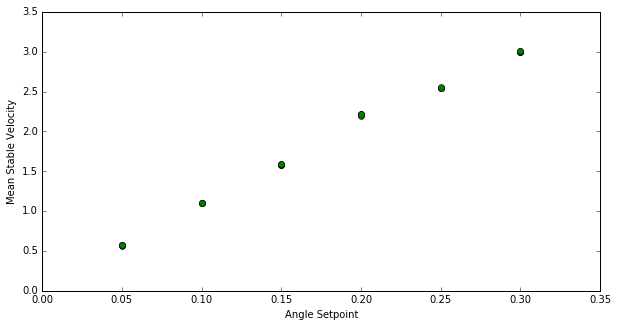

In [213]:
plt.figure().set_size_inches(10, 5)
for a, vels in vs.items():
    colors = 'rgbkygo'
    for v2, v in enumerate(vels):
        plt.plot(a,v,colors[v2]+'o')
    
plt.xlabel("Angle Setpoint")
plt.ylabel("Mean Stable Velocity")
plt.xlim([0,0.35])
plt.ylim([0,3.5])


(0, 3.5)

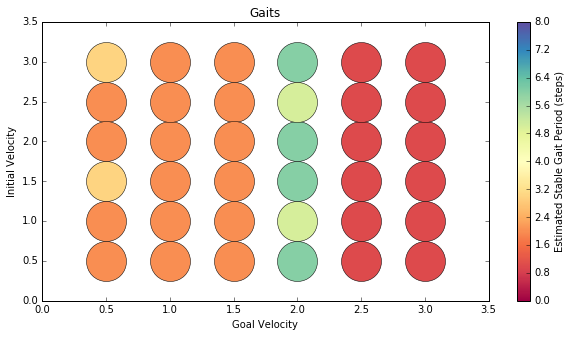

In [229]:
plt.figure().set_size_inches(10, 5)
plt.title("Gaits")
plt.xlabel('Goal Velocity')
plt.ylabel('Initial Velocity')



cmap = plt.cm.ScalarMappable(cmap = 'Spectral')
cmap.set_array(np.array(range(9)))

cbar = plt.colorbar(cmap)
cbar.set_label("Estimated Stable Gait Period (steps)")

for (v1,v2),p in periods.items():
    plt.plot(v1,v2, color = cmap.to_rgba([p])[0], marker = 'o', markersize = 40)

plt.xlim([0,3.5])
plt.ylim([0,3.5])